In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import time

In [ ]:
#!pip install celluloid


[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: C:\Users\casey\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [64]:
import celluloid

Research question: how important is free throw differential? The Bucks are last in free throws made, and 5th highest in free throws given up, about a 7 point difference. how much does having a negative/positive differential affect winning?


get opponent free throws made from: https://www.nba.com/stats/teams/opponent?dir=D&sort=OPP_FTM

get free throws made from: https://www.nba.com/stats/teams/traditional?dir=A&sort=FTM

opponent stats url:
https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&Height=&ISTRound=&LastNGames=0&LeagueID=00&Location=&MeasureType=Opponent&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2025-26&SeasonSegment=&SeasonType=Regular Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=

own stats url:
GET
	https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&Height=&ISTRound=&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=2025-26&SeasonSegment=&SeasonType=Regular Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision=

In [3]:
## FIXME: generalize this function for various NBA dashboards, to grab both of the above

def opponent_url():

    return "https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=" + \
                    "&GameSegment=&Height=&ISTRound=&LastNGames=0&LeagueID=00&Location=&MeasureType=Opponent&Month=0&OpponentTeamID=0" + \
                    "&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N" + \
                    "&Season=%(season)s&SeasonSegment=&SeasonType=Regular Season&ShotClockRange=&StarterBench=&TeamID=0&TwoWay=0&VsConference=&VsDivision="

    # the_url = url_template % {'season' : season}
    # return the_url

def own_url():
    return "https://stats.nba.com/stats/leaguedashteamstats?Conference=&DateFrom=&DateTo=&Division=&GameScope=&GameSegment=&Height=&ISTRound=" +\
        "&LastNGames=0&LeagueID=00&Location=&MeasureType=Base&Month=0&OpponentTeamID=0&Outcome=&PORound=0&PaceAdjust=N&PerMode=PerGame&Period=0" +\
        "&PlayerExperience=&PlayerPosition=&PlusMinus=N&Rank=N&Season=%(season)s&SeasonSegment=&SeasonType=Regular Season&ShotClockRange=&StarterBench=" +\
        "&TeamID=0&TwoWay=0&VsConference=&VsDivision="


In [ ]:
## FIXME: these are copy-pasted from another notebook...put it in its own library

headers = {
    'User-Agent': "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:145.0) Gecko/20100101 Firefox/145.0",
    'Referer' : "https://www.nba.com",
    'Origin'  : "https://www.nba.com",
    "Sec-GPC" : "1",
    "Sec-Fetch-Dest": "empty",
    "Sec-Fetch-Mode": "cors",
    "Sec-Fetch-Site": "same-site"
}


def get_data_for_season(season="2025-26"):
    # get own data
    url = own_url() % {'season' : season}
    r = requests.get(url, headers=headers)
    req_json =  r.json()['resultSets'][0]
    df = pd.DataFrame(req_json['rowSet'], columns=req_json['headers'])
    own_data = df.set_index("TEAM_NAME")

    # get opponent data
    url = opponent_url() % {'season' : season}
    r = requests.get(url, headers=headers)
    req_json =  r.json()['resultSets'][0]
    df = pd.DataFrame(req_json['rowSet'], columns=req_json['headers'])
    opponent_data = df.set_index("TEAM_NAME")

    # find and nuke potential duplicate columns
    # from https://www.geeksforgeeks.org/python/prevent-duplicated-columns-when-joining-two-pandas-dataframes/
    different_cols = own_data.columns.difference(opponent_data.columns)
    own_unique = own_data[different_cols].copy()

    # merge them

    return pd.concat([own_unique,opponent_data], axis=1)
    


In [37]:
def fetch_seasons(start_year=15, end_year=26):
    years = [x for x in range(start_year, end_year)]

    dataframes = []
    for year in years:
        year_param = "20%d-%d" % (year, year+1)
        df = get_data_for_season(year_param)
        df['SEASON'] = year
        dataframes.append(df)
        print(f"did {year_param}")
        time.sleep(2)

    df = pd.concat(dataframes)
    return df
    

In [ ]:
all_data = fetch_seasons()

did 2015-16
did 2016-17
did 2017-18
did 2018-19
did 2019-20
did 2020-21
did 2021-22
did 2022-23
did 2023-24
did 2024-25
did 2025-26


pretty strong correlation between opponent free throws made, and number of wins

In [42]:
all_data.W.corr(all_data.OPP_FTM)

np.float64(-0.4054101929730513)

it's less strong than the free throw differential.

In [43]:
all_data.W.corr(all_data.OPP_FTM - all_data.FTM)

np.float64(-0.23918755674695252)

the correlation is weaker with a team's own number of free throws made.

In [44]:
all_data.W.corr(all_data.FTM)

np.float64(-0.1252438572691674)

blocks are interesting, they matter more than I would think

In [66]:
all_data.W.corr(all_data.BLK)

np.float64(0.21091901381505945)

blocks against is way more important than blocks for

In [65]:
all_data.W.corr(all_data.OPP_BLK)

np.float64(-0.4096018341244084)

In [51]:
all_data.loc[:, ["W_RANK", "OPP_BLK"]]

,W_RANK,OPP_BLK
TEAM_NAME,,
Atlanta Hawks,7,5.0
Boston Celtics,7,5.5
Brooklyn Nets,28,5.2
Charlotte Hornets,7,5.5
Chicago Bulls,14,5.7
...,...,...
Sacramento Kings,25,5.0
San Antonio Spurs,5,4.1
Toronto Raptors,3,5.7


In [56]:
all_data.columns

Index(['AST', 'AST_RANK', 'BLK', 'BLKA', 'BLKA_RANK', 'BLK_RANK', 'DREB',
       'DREB_RANK', 'FG3A', 'FG3A_RANK', 'FG3M', 'FG3M_RANK', 'FG3_PCT',
       'FG3_PCT_RANK', 'FGA', 'FGA_RANK', 'FGM', 'FGM_RANK', 'FG_PCT',
       'FG_PCT_RANK', 'FTA', 'FTA_RANK', 'FTM', 'FTM_RANK', 'FT_PCT',
       'FT_PCT_RANK', 'OREB', 'OREB_RANK', 'PF', 'PFD', 'PFD_RANK', 'PF_RANK',
       'PTS', 'PTS_RANK', 'REB', 'REB_RANK', 'STL', 'STL_RANK', 'TOV',
       'TOV_RANK', 'TEAM_ID', 'GP', 'W', 'L', 'W_PCT', 'MIN', 'OPP_FGM',
       'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M', 'OPP_FG3A', 'OPP_FG3_PCT',
       'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB', 'OPP_DREB', 'OPP_REB',
       'OPP_AST', 'OPP_TOV', 'OPP_STL', 'OPP_BLK', 'OPP_BLKA', 'OPP_PF',
       'OPP_PFD', 'OPP_PTS', 'PLUS_MINUS', 'GP_RANK', 'W_RANK', 'L_RANK',
       'W_PCT_RANK', 'MIN_RANK', 'OPP_FGM_RANK', 'OPP_FGA_RANK',
       'OPP_FG_PCT_RANK', 'OPP_FG3M_RANK', 'OPP_FG3A_RANK', 'OPP_FG3_PCT_RANK',
       'OPP_FTM_RANK', 'OPP_FTA_RANK', 'OPP_FT_P

there is some correlation between getting a lot of free throws, and giving up a lot of them.

I think this is because it's seasonal data. The base rate of number of free throws called goes up and down season-to-season, so the numbers should be a bit correlated with each other.

In [67]:
all_data.FTM.corr(all_data.OPP_FTM)

np.float64(0.3111962627476356)

In [62]:
all_data.SEASON.value_counts()

SEASON
15    30
16    30
17    30
18    30
19    30
20    30
21    30
22    30
23    30
24    30
25    30
Name: count, dtype: int64

# Evolution of free throw rates
How have free throw rates changed over time?

An animated scatterplot (by season) would be cool.

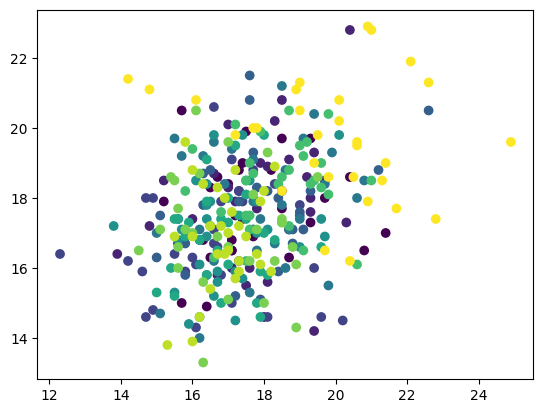

In [61]:
plt.scatter(all_data.FTM, all_data.OPP_FTM, c=all_data.SEASON)

In [104]:
plt.style.use('dark_background')

MovieWriter ffmpeg unavailable; using Pillow instead.


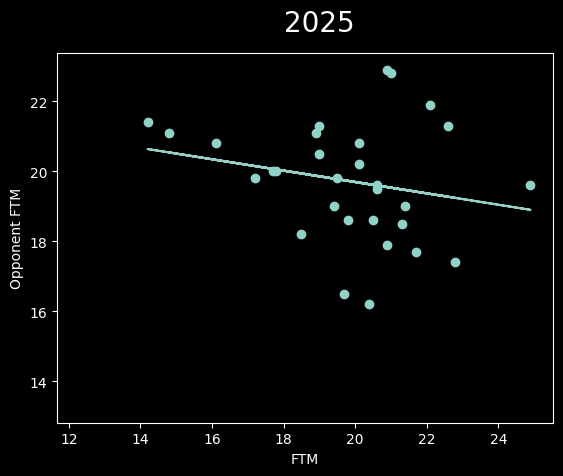

In [113]:
from celluloid import Camera


fig, ax = plt.subplots()

cam = Camera(fig)

for season in all_data.SEASON.unique():
    this_season = all_data[all_data.SEASON == season]
    t = ax.scatter(this_season.FTM, this_season.OPP_FTM, label=season)
    ax.text(18, 24, f"20{season}", size=20)
    ax.set_xlabel("FTM")
    ax.set_ylabel("Opponent FTM")
    
    ## add trendline
    trend_fit = np.polyfit(this_season.FTM, this_season.OPP_FTM, 1)
    trend_line = np.poly1d(trend_fit)
    plt.plot(this_season.FTM, trend_line(this_season.FTM))


    #fig.title(str(season))
    #plt.legend(t, [str(season)])
    cam.snap()

anim = cam.animate()
anim.save("ftm_scatter.gif", fps=1)
plt.show()